In [1]:
import os
import re
import numpy as np

try:
  import pytorch_lightning as pl
except: 
  !pip install pytorch-lightning==1.2.10
  import pytorch_lightning as pl
    
try:
    from Bio import SeqIO
except:
    !pip install biopython
    from Bio import SeqIO
    
# Download repo if notebook is taken out of context (e.g. by colab)
if not os.path.exists('models'):
    !git clone https://github.com/MachineLearningLifeScience/What-is-a-meaningful-representation-of-protein-sequences tmp_clone
    !mv tmp_clone/* .
    !rm -rf tmp_clone

if not os.path.exists('PF00144_full_labeled.fasta'):
    !wget https://sid.erda.dk/share_redirect/a5PTfl88w0/PF00144_full_labeled.fasta

  Using cached pytorch_lightning-1.2.10-py3-none-any.whl (841 kB)
  Using cached torch-1.9.0-cp38-cp38-manylinux1_x86_64.whl (831.4 MB)
  Using cached torchmetrics-0.2.0-py3-none-any.whl (176 kB)
  Using cached PyYAML-5.3.1-cp38-cp38-linux_x86_64.whl
  Using cached tensorboard-2.6.0-py3-none-any.whl (5.6 MB)
  Using cached aiohttp-3.7.4.post0-cp38-cp38-manylinux2014_x86_64.whl (1.5 MB)
  Using cached absl_py-0.13.0-py3-none-any.whl (132 kB)
     |████████████████████████████████| 152 kB 5.0 MB/s eta 0:00:01
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cached protobuf-3.17.3-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.0 MB)
  Using cached grpcio-1.40.0-cp38-cp38-manylinux2014_x86_64.whl (4.3 MB)
  Using cached tensorboard_data_server-0.6.1-py3-none-manylinux2010_x86_64.whl (4.9 MB)
  Using cached tensorboard_plugin_wit-1.8.0-py3-none-any.whl (781 kB)
  Using cached Markdown-3.3.4-py3-none-any.whl (97 kB)
  Using cached pyasn1_modules-0.2.8-p

# Load VAE models

In [2]:
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn.functional as F

from models.vae_geometric import VAE, get_hparams, aa1_to_index, aa1

def get_data(data_filename, calc_weights=True, similarity_threshold=0.8):
    ids = []
    labels = []
    seqs = []
    label_re = re.compile(r'\[([^\]]*)\]')
    for record in SeqIO.parse(data_filename, "fasta"):
        ids.append(record.id)
        labels.append(label_re.search(record.description).group(1))
        seqs.append(np.array([aa1_to_index[aa] for aa in str(record.seq).upper().replace('.', '-')]))
        
    seqs = torch.from_numpy(np.vstack(seqs))
    labels = np.array(labels)

    weights = None
    if calc_weights is not False:

        # Experiencing memory issues on colab for this code because pytorch doesn't
        # allow one_hot directly to bool. Splitting in two and then merging.
        # one_hot = F.one_hot(seqs.long()).to('cuda' if torch.cuda.is_available() else 'cpu')
        one_hot1 = F.one_hot(seqs[:len(seqs)//2].long()).bool()
        one_hot2 = F.one_hot(seqs[len(seqs)//2:].long()).bool()
        one_hot = torch.cat([one_hot1, one_hot2]).to('cuda' if torch.cuda.is_available() else 'cpu')
        assert(len(seqs) == len(one_hot))
        del one_hot1
        del one_hot2
        one_hot[seqs>19] = 0
        flat_one_hot = one_hot.flatten(1)

        weights = []
        weight_batch_size = 1000
        flat_one_hot = flat_one_hot.float()
        for i in range(seqs.size(0) // weight_batch_size + 1):
            x = flat_one_hot[i * weight_batch_size : (i + 1) * weight_batch_size]
            similarities = torch.mm(x, flat_one_hot.T)
            lengths = (seqs[i * weight_batch_size : (i + 1) * weight_batch_size] <=19).sum(1).unsqueeze(-1).to('cuda' if torch.cuda.is_available() else 'cpu')
            w = 1.0 / (similarities / lengths).gt(similarity_threshold).sum(1).float()
            weights.append(w)
            # plt.hist(similarities/lengths)
            
        weights = torch.cat(weights)
        neff = weights.sum()

    return ids, seqs, labels, weights

# Note that we deviate from the normal choice of 0.8 for the similarity threshold. This is 
# Due to the PFAM alignment being extremely long, with lots of positions matching gaps.
ids, data, labels, weights = get_data("PF00144_full_labeled.fasta", calc_weights=True, similarity_threshold=0.6)
print(weights)

#import matplotlib.pyplot as plt
#plt.hist(weights, bins=100)

/home/nsde/Documents/meaningful-protein-representations/models/geoml/curve.py:79: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if len(begin) is 1 or begin.shape[0] is 1:
/home/nsde/Documents/meaningful-protein-representations/models/geoml/curve.py:79: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if len(begin) is 1 or begin.shape[0] is 1:
/home/nsde/Documents/meaningful-protein-representations/models/geoml/curve.py:83: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if len(end) is 1 or end.shape[0] is 1:
/home/nsde/Documents/meaningful-protein-representations/models/geoml/curve.py:83: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if len(end) is 1 or end.shape[0] is 1:
/home/nsde/Documents/meaningful-protein-representations/models/geoml/curve.py:144: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if len(begin) is 1 or begin.shape[0] is 1:
/home/nsde/Documents/meaningful-protein-representations/models/geoml/curve.py:144: SyntaxWarning:

tensor([1.0000, 0.0500, 0.0333,  ..., 1.0000, 1.0000, 0.5000], device='cuda:0')


In [3]:
import time
def train_or_retrieve_model(name, data, weights, train_model, uncertainty_temperature):
    
    cmd_args = []
    if train_model:
        cmd_args += ['-gpu', '1' if torch.cuda.is_available() else '']
    else:
        cmd_args += ['-load_from', name+'.ckpt', '-gpu', '1' if torch.cuda.is_available() else '']
    hparams = get_hparams(cmd_args)

    pl.seed_everything(hparams.seed)

    perm = np.random.permutation(data.shape[0])
    
    if hparams.load_from!='':
        
        if not os.path.exists(hparams.load_from):
            filename = os.path.join('https://sid.erda.dk/share_redirect/a5PTfl88w0/', hparams.load_from)
            !wget $filename
        
        print('Loading from checkpoint!')
        model = VAE.load_from_checkpoint(checkpoint_path=hparams.load_from, data=data, perm=perm, weights=weights)

        # for some reason these where not correctly saved in the checkpoint
        model.switch = True
        
        # Trigger retraining of distnet, since this does not seem to be saved properly in checkpoint
        model.distnet.initialized = False
        
        # Model fit specific parameter setting the temperature of the uncertainty
        model.distnet.trans.beta.data = torch.tensor([uncertainty_temperature])
        
    else:
        print('Training model!')
        model = VAE(data=data, weights=weights, perm=perm, hparams=hparams)
        trainer = pl.Trainer(gpus=1 if hparams.gpu else 0,
                             max_epochs=hparams.epochs)
        trainer.fit(model)
        
        trainer.save_checkpoint(name+'_{}.ckpt'.format(time.strftime("%Y%m%d")))

    return model

In [16]:
# Options
train_models = False

model_pf00144 = train_or_retrieve_model('model_PF00144', 
                                        data,
                                        weights=None,
                                        train_model=train_models,
                                        uncertainty_temperature=-3.5)
model_pf00144_reweighted = train_or_retrieve_model('model_PF00144_reweighted_0.4', 
                                                   data,
                                                   weights=weights,
                                                   train_model=train_models,
                                                   uncertainty_temperature=-3.5)
models = [model_pf00144, model_pf00144_reweighted]

Global seed set to 123


Loading from checkpoint!


Global seed set to 123


Loading from checkpoint!


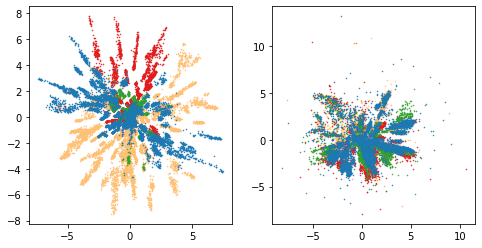

In [17]:
embeddings = []
for model in [model_pf00144, model_pf00144_reweighted]:
    embeddings.append([])
    batchsize = 16
    n_batch = int(np.ceil(model.data.shape[0] / batchsize))
    for b in range(n_batch):
        batch = model.data[b*batchsize:(b+1)*batchsize]
        zs = model.embedding(batch.long().to(model._device))
        embeddings[-1].append(zs.detach())
    embeddings[-1] = np.vstack(embeddings[-1])
    

phyla = ['Acidobacteria', 'Actinobacteria', 'Bacteroidetes',
         'Chloroflexi', 'Cyanobacteria', 'Deinococcus-Thermus',
         'Firmicutes', 'Fusobacteria', 'Proteobacteria']#, 'Other']
            
import matplotlib.pyplot as plt

# Color coding of organisms
colors = [[106,61,154],
          [254,192,113],
          [226,28,29],
          [250,155,153],
          [252,129,2],
          [168,206,227],
          [51,162,45],
          [179,225,139],
          [28,121,179],
          [193,193,193]]
colors = np.array(colors) / 255.0
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for idx,_ in enumerate(embeddings):
    for i in range(len(phyla)):
        ax[idx].plot(embeddings[idx][labels==phyla[i],0],
                     embeddings[idx][labels==phyla[i],1],
                     '.', color=colors[i], label=phyla[i], markersize=1)    


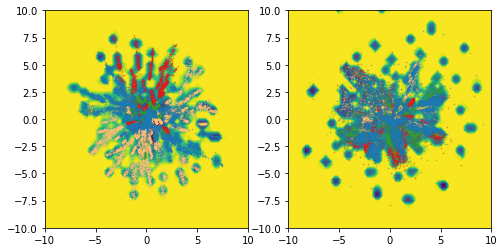

In [18]:
# latent space entropy
from torch import distributions as D
fig, ax = plt.subplots(1, 2, figsize=(8,4))
n_points = 50
z_grid = torch.stack([m.flatten() for m in torch.meshgrid(2*[torch.linspace(-10, 10, n_points)])]).t()
for idx, model in enumerate([model_pf00144, model_pf00144_reweighted]):
    recon = model.decode(z_grid, as_probs=True)
    d = D.Categorical(probs=recon.permute(0,2,1))
    entropy = d.entropy().sum(dim=-1)
    
    for i in range(len(phyla)):
        ax[idx].plot(embeddings[idx][labels==phyla[i],0],
                     embeddings[idx][labels==phyla[i],1],
                     '.', color=colors[i], label=phyla[i], 
                     markersize=1, alpha=0.5)
        
    ax[idx].contourf(z_grid[:,0].reshape(n_points, n_points),
                     z_grid[:,1].reshape(n_points, n_points),
                     entropy.log().reshape(n_points, n_points).detach(),
                     levels=50)
    
    ax[idx].axis([-10, 10, -10, 10])


# Phylogenetic tree

In [19]:
# Options
run_preprocessing = False
n_samples = 500

phylo_ids = []
for record in SeqIO.parse('PF00144_full_labeled.fasta', "fasta"):
    phylo_ids.append(record.id.split('/')[0])
    
if run_preprocessing:

    !FastTree > /dev/null
    if exit_code != 0:
                    
        # Attempt at making script self-contained by installing FastTree via conda. 
        # Seems to work on colab, but might not be super robust
        !conda --version
        if _exit_code != 0:
            !pip install -q condacolab
            import condacolab
            condacolab.install()
        
        !conda install -c bioconda fasttree 
    
    # Estimate tree
    !FastTree < PF00144_full.txt > PF00144_tree.txt

else:
    # Retrieve Beta-lactamase tree file
    if not os.path.exists('PF00144_tree.txt'):
        !wget https://sid.erda.dk/share_redirect/a5PTfl88w0/PF00144_tree.txt    
    

--2021-09-10 09:37:14--  https://sid.erda.dk/share_redirect/a5PTfl88w0/PF00144_tree.txt
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1663691 (1.6M) [text/plain]
Saving to: ‘PF00144_tree.txt’

PF00144_tree.txt    100%[===================>]   1.59M  --.-KB/s    in 0.05s   

2021-09-10 09:37:14 (32.4 MB/s) - ‘PF00144_tree.txt’ saved [1663691/1663691]



In [20]:
try:
    from Bio import Phylo
except:
    !pip install biopython
    from Bio import Phylo

class TreeDist(object):
    def __init__(self, filename):
        self.tree = next(Phylo.parse(filename, 'newick'))
        self.leaves = list(self.tree.get_terminals())
        
        self.leaf_lookup = {}
        for i, leaf in enumerate(self.leaves):
            self.leaf_lookup[leaf.name] = i

    def id_to_id_dist(self, id1, id2):

        idx1 = self.leaf_lookup[id1]
        idx2 = self.leaf_lookup[id2]

        return self.tree.distance(self.leaves[idx1],
                                  self.leaves[idx2])
    
td = TreeDist("PF00144_tree.txt")

print("Leaves: ", len(td.leaves))

Leaves:  36328


In [22]:
import scipy.stats
import pandas as pd

dms = []
for model in models:
    # Create grid and calculate discretized version of manifold, so that geodesics can be calculated using
    # graph algorithm
    n_points = 100
    z_grid = torch.stack([m.flatten() for m in torch.meshgrid(2*[torch.linspace(-10,10,n_points)])]).t()

    from models.geoml.manifold import EmbeddedManifold, CubicSpline
    from models.geoml.discretized_manifold import DiscretizedManifold
    print('\n Creating discretized manifolds')
    dms.append(DiscretizedManifold(model, z_grid.t().reshape(2,n_points,n_points), use_diagonals=True))


 Creating discretized manifolds

 Creating discretized manifolds


In [23]:
n_repetitions = 1
distances = []
for i in range(n_repetitions):
    
    # Random indices
    sample_idx_i = np.random.choice(len(data), n_samples)
    sample_idx_j = np.random.choice(len(data), n_samples)

    print('\n Calculating phylogenetic distances')
    phylo_distances = []
    for i, j in zip(sample_idx_i, sample_idx_j):
        phylo_distances.append(td.id_to_id_dist(ids[i], 
                                                ids[j]))
        
    print('\n Calculating VAE distances')
    vae_distances = []
    for i, j in zip(sample_idx_i, sample_idx_j):
        em1 = embeddings[0][i]
        em2 = embeddings[0][j]
        vae_distances.append(np.linalg.norm(em1-em2))

    print('\n Calculating VAE geodesics')
    vae_geo_distances = []
    for i, j in zip(sample_idx_i, sample_idx_j):
        em1 = embeddings[0][i]
        em2 = embeddings[0][j]
        curve, dist = dms[1].shortest_path(em1, em2)
        #curve = dms[0].connecting_geodesic(torch.tensor(em1).reshape(1,-1), torch.tensor(em2).reshape(1,-1),
        #                                   CubicSpline(torch.tensor(em1).reshape(1,-1), torch.tensor(em2).reshape(1,-1), num_nodes=10))
        #dist = float(models[0].curve_length(curve(torch.linspace(0, 1, 100))))
        vae_geo_distances.append(dist)
        
    print('\n Calculating VAE (reweighted) distances')
    vae_distances_w = []
    for i, j in zip(sample_idx_i, sample_idx_j):
        em1 = embeddings[1][i]
        em2 = embeddings[1][j]
        vae_distances_w.append(np.linalg.norm(em1-em2))

    print('\n Calculating Hamming distances')
    hamming_distances = []
    for i, j in zip(sample_idx_i, sample_idx_j):
        hamming_distances.append(scipy.spatial.distance.hamming(data[i], data[j]))
        
    distances.append({'phylo':phylo_distances, 
                      'vae':vae_distances, 
                      'vae_geo':vae_geo_distances, 
                      'vae_w':vae_distances_w, 
                      'hamming':hamming_distances})
distances = pd.DataFrame(distances)


 Calculating phylogenetic distances

 Calculating VAE distances

 Calculating VAE geodesics

 Calculating VAE (reweighted) distances

 Calculating Hamming distances


vae Pearson: 0.22 ± 0.00
Spearman: 0.25 ± 0.00
vae_geo Pearson: 0.09 ± 0.00
Spearman: 0.17 ± 0.00
vae_w Pearson: 0.40 ± 0.00
Spearman: 0.38 ± 0.00
hamming Pearson: 0.33 ± 0.00
Spearman: 0.30 ± 0.00


<ipython-input-24-41a3a04de50d>:54: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coeff_a, _, _, _ = np.linalg.lstsq(x[:,np.newaxis], y)
<ipython-input-24-41a3a04de50d>:54: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coeff_a, _, _, _ = np.linalg.lstsq(x[:,np.newaxis], y)
<ipython-input-24-41a3a04de50d>:54: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pa

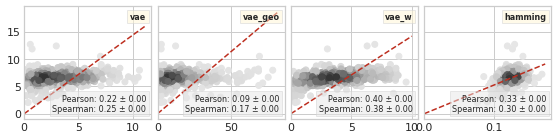

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from scipy.stats import gaussian_kde
import matplotlib.colors as colors
import scipy.stats
import seaborn as sns
sns.set_theme(style="whitegrid")

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

red = [.74, .18, .12]
yellow = "#fff6d5"
cmap = truncate_colormap(plt.get_cmap('gray_r'), 0.1, 0.80)


fig, ax = plt.subplots(1, len(distances.columns)-1, sharex=False, sharey=True, figsize=(8,2.))
plt.subplots_adjust(wspace=0.05, hspace=0.0, left=0.075, right=0.99, bottom=0.2, top=0.98)

for idx, model in enumerate(distances.loc[:, distances.columns != 'phylo']):
    
    xs = np.array(distances[model].to_list())
    ys = np.array(distances['phylo'].to_list())
    
    spearmans = []
    pearsons = []
    for repetition in range(xs.shape[0]):
        
        x = xs[repetition]
        y = ys[repetition]
        
        spearmans.append(scipy.stats.spearmanr(x, y).correlation)
        pearsons.append(np.corrcoef(x,y)[0,1])

    corr_str = """Pearson: {:.2f} ± {:.2f}\nSpearman: {:.2f} ± {:.2f}""".format(np.mean(pearsons), 
                                                                                np.std(pearsons), 
                                                                                np.mean(spearmans), 
                                                                                np.std(spearmans))
    
    print(model, corr_str)
    
    # Visualize first repetition
    x = xs[0]
    y = ys[0]
    
    xy = np.vstack([x,y])

    z = gaussian_kde(xy)(xy)

    coeff_a, _, _, _ = np.linalg.lstsq(x[:,np.newaxis], y)
    #coef = np.polyfit(x,y,1)
    #poly1d_fn = np.poly1d(coef)

    title = model

    ax[idx].scatter(x, y, c=z, cmap=cmap)

    line_x = np.linspace(0, ax[idx].get_xlim()[1], 500)
    line_y = coeff_a*line_x
    ax[idx].plot(line_x, line_y, '--', color=red)

    ax[idx].tick_params(axis='both', which='major', pad=-3)
    
    props = dict(boxstyle='square', facecolor=yellow, edgecolor='lightgrey', alpha=0.5, )

    ax[idx].text(0.96, 0.95, title, transform=ax[idx].transAxes, fontsize=8,
               verticalalignment='top', horizontalalignment='right', bbox=props, fontweight='bold')

    props = dict(boxstyle='square', facecolor="0.9", edgecolor='lightgrey', alpha=0.5)

    ax[idx].text(0.96, 0.05, corr_str, transform=ax[idx].transAxes, fontsize=8,
               verticalalignment='bottom', horizontalalignment='right', bbox=props)

    ax[idx].set_xlim(left=0)

# Visualizing geodesics

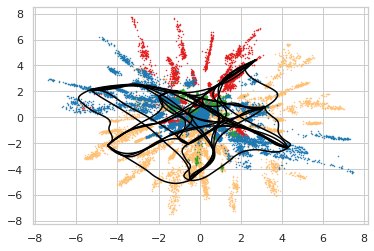

In [25]:
# Color coding of organisms
colors = [[106,61,154],
          [254,192,113],
          [226,28,29],
          [250,155,153],
          [252,129,2],
          [168,206,227],
          [51,162,45],
          [179,225,139],
          [28,121,179],
          [193,193,193]]
colors = np.array(colors) / 255.0
for i in range(len(phyla)):
    plt.plot(embeddings[0][labels==phyla[i],0],
             embeddings[0][labels==phyla[i],1],
             '.', color=colors[i], label=phyla[i], markersize=1)   


ids_shortened = [id.split('/')[0] for id in ids]
representative_point_labels = ['A0A1S9B261_9BACT', 'A0A1N6S5V9_9SPHI', 'A0A0G3XB70_9SPHN', 'A0A124H8F2_9ACTN', 'A0A0H0XMZ2_9SPHN', 'A0A1H3MS29_9MICO', 'A0A1C4RXZ6_9ACTN', 'K6YB53_9ALTE', 'D7BUJ0_STRBB', 'V4PEL1_9CAUL', 'A0A0R2T7U0_9GAMM', 'W6TRC3_9SPHI', 'A0A095V1K0_9FLAO', 'H5UKC9_9ACTN', 'A0A086GHA9_STRSC', 'I0K217_9BACT', 'A0A1E5SZ29_9BACT', 'A0A162YSP3_9FLAO', 'A0A1J4NQQ5_9ACTN', 'U5VSN6_9ACTN', 'A0A1C4SSD9_9ACTN', 'A0A1W9IDH3_9PROT', 'A0A142HQP5_9SPHI', 'A0A1S1R3M6_9ACTN', 'A0A1I1BJF2_9RHIZ', 'U5EQF0_NOCAS', 'A0A0X3XPR2_9ACTN', 'H6R079_NOCCG', 'A0A117P596_9ACTN', 'A0A1A1WA84_9MYCO', 'A0A0P1E0C4_9RHOB', 'A0A1A1W888_9MYCO', 'A0A1H7JGC4_9FLAO', 'A0A239H288_9ACTN', 'A0A1Q3TL54_9SPHI', 'K4KU84_SIMAS', 'A0A1I5UY06_9BURK', 'R1I1M6_9PSEU', 'Q1QJW4_NITHX', 'A0A132PRK9_9MYCO', 'A0A1U9RJ97_9PROT', 'A0A1M7RYP7_9SPHN', 'A0A1B2AFT2_9SPHN', 'A0A0A0M5Y1_9GAMM', 'A0A0F5VWV8_9ACTN', 'I2GLG1_9BACT', 'A0A0F7FX81_9ACTN', 'A0A1G8H815_9FLAO', 'A0A1X1XXI8_9MYCO', 'A0A239D989_9ACTN', 'A0A1V6MS15_9ACTN', 'A0A1H5P1R8_9ACTN', 'A0A1I5FZY5_9PSEU', 'A0A0X8G8M6_9FLAO', 'A0A0B4C4Z4_9RHOB', 'A0A1A3JFC6_9MYCO', 'F6FTL6_ISOV2', 'R6TPJ2_9FIRM', 'A0A0A8E0Q6_9XANT', 'A0A1I7E112_9BURK', 'A0A1I0K8Y1_9ACTN', 'A0A1Q5RAV8_9BRAD', 'A6GGG0_9DELT', 'F9UGM4_9GAMM', 'C1AR94_RHOOB', 'A0A1M5PIZ9_9PSED', 'A4YSH1_BRASO', 'A0A1C5D6B7_9ACTN', 'A0A1B9SCE0_9RHIZ', 'A0A1H5RFB9_9PSEU', 'A0A1H6K407_9FLAO', 'A0A1I5LQF8_9PSEU', 'A0A101P567_9ACTN', 'A0A1W9HH69_9PROT', 'A0A1C5GGB8_9ACTN', 'A0A1H9UFK4_9PSEU', 'C6XX09_PEDHD', 'A0A1N7D2Y2_9SPHI', 'A0A0M9ZF93_9ACTN', 'A0A1I3JVY2_9FLAO', 'A0A1Q5XM94_9BACL', 'A0A086GTC1_STRSC', 'A0A0Q3PHY5_9BRAD', 'X5L994_9MYCO', 'A8FUC9_SHESH', 'A0A1Q4AJT7_9RHIZ', 'A0A1R0U5T5_9MYCO', 'A0A239E4N3_9SPHN', 'A0A1W9Z6U0_9MYCO', 'A0A1E7N9T9_KITAU', 'A0A0D8ZT94_9CYAN', 'U5W069_9ACTN', 'A0A1X1TEX7_9MYCO', 'E3IVP0_FRAIE', 'A0A238W6P2_9FLAO', 'A0A0S2KGP0_9GAMM', 'A0A150X572_9BACT', 'A0A0P1HDX4_9RHOB', 'A0A1X1Y8Z0_9MYCO', 'A0A1T3NKX6_9ACTN', 'A0A1E5T8M3_9FLAO', 'W6RMK2_9RHIZ', 'D2QF15_SPILD', 'A0A172YP11_9GAMM', 'A0A1G9IS36_9FIRM', 'A0A0P0NER0_9SPHI', 'A0A1H2Z8U6_9FLAO', 'I4N9E9_9PSED', 'H6NNS0_9BACL', 'A0A0Q6U7Q0_9CAUL', 'A0A1I1NQA5_9FLAO', 'W6K0N3_9MICO', 'A0A059FAG0_9RHOB', 'A0A239UAQ6_9STAP', 'A0A0Q4CCW5_9SPHN', 'A0A1H7Z0C3_9BACL', 'I8XTV4_9BACE', 'A0A0Q9SNL5_9MICO', 'A0A0L0KUC6_9ACTN', 'A0A1M3DBI3_9SPHN', 'A0A0Q4CCV4_9FLAO', 'A0A0Q6LBM4_9RHIZ', 'A0A0D6P7R6_9PROT', 'A0A2D8REK4_9GAMM', 'A0A1I6MH08_9MICO', 'A0A1Z2KUI0_9ACTN', 'A5FKQ3_FLAJ1', 'A0A1I1L7I8_9GAMM', 'A0A1G9VIM6_9PSEU', 'A0A0K2YPP4_9NOCA', 'A0A172ZMD5_9BACL', 'A0A117P8A7_9ACTN', 'A0A0M2VW43_9BACL', 'A0A1X7LEJ3_9BACT', 'A0A1G8MTV3_9BRAD', 'A0A1G9UIX5_9ACTN', 'A0A2G1UKI9_9ALTE', 'A0A1I4ZAY4_9ACTN', 'A0A091BUD4_9ENTE', 'A0A1G9SC39_9BACT', 'A0A117QQC3_9ACTN', 'A0A246JGM2_9SPHN', 'G2YZY5_FLABF', 'A0A1A1XCB1_9MYCO', 'A0A1G6EYF3_9FLAO', 'A0A1W1UTZ2_9DEIO', 'A0A1H0LUA7_9PSEU', 'A0A0D7N702_9BRAD', 'A0A139V867_MYCPH', 'A0A0Q7T9N7_9CAUL', 'A0A075P8I6_9ALTE', 'F5XN73_MICPN', 'A0A1N6TB30_9ACTN', 'A0A0S2F7W1_9GAMM', 'A0A0W1FDQ5_9SPHN', 'A0A1F4HNF0_9BURK', 'A0A0S7B6I6_9CHLR', 'A0A1M7RNK4_9ACTN', 'D9VTC3_9ACTN', 'A0A1I4H5E7_9BACI', 'A0A1I6MHH8_9MICO', 'A0A0N1C0K0_9SPHN', 'A0A0S7BU80_9BACT', 'A0A1E5UCX4_9FLAO', 'A0A0T1QBY4_9ACTN', 'A0A1I7HTB7_9BRAD', 'A0A0J8YTA7_9BACT', 'A0A0Q5LNR9_9MICO', 'W6RC31_9RHIZ', 'A0A1H9IED7_9GAMM', 'A0A2C9XTS2_9ENTE', 'A0A0A7JHS1_9PSED', 'A0A0G3M0P2_9FLAO', 'A0A257J7M5_9PROT', 'A0A0Q4RYS2_9FLAO', 'A0A0X8E1F4_9MICO', 'A0A1H3JYW4_9ACTN', 'A0A1S8D874_9PROT', 'A0A1K2FJD7_9ACTN', 'A0A0M8XWS4_9ACTN', 'A0A1L7D1X1_9CORY', 'A0A0S2K5Z8_9GAMM', 'A0A1C2EAC3_9RHIZ', 'A0A086N7F9_9ACTN', 'A0A172TI00_9BACL', 'A0A1N7N8U5_9RHOB', 'A0A127JZQ8_9BURK', 'A0A0Q4MDP1_9GAMM', 'A0A074M2K7_9SPHN', 'A0A1S6FJP8_9SPHN', 'A0A1R1SC01_9ACTN', 'A0A1A3MVE7_MYCAS', 'B0T1W0_CAUSK', 'A0A0Q5UMQ3_9FLAO', 'K0ELR6_9NOCA', 'C9ZH94_STRSW', 'A0A100Y6W1_9ACTN', 'A0A1H4IQL5_9FLAO', 'A0A0M8XHR7_9ACTN', 'A0A1A1Y6V6_9MYCO']
representative_point_ids = []
for label in representative_point_labels:
    representative_point_ids.append(ids_shortened.index(label))

# Limit ourselves to a few points for testing
representative_point_ids = representative_point_ids[:10]
    
for i in range(len(representative_point_ids)):
    for j in range(i+1, len(representative_point_ids)):
        
        p1 = embeddings[0][representative_point_ids[i]]
        p2 = embeddings[0][representative_point_ids[j]]

        #curve, dist = dms[0].shortest_path(p1, p2)
        curve = dms[0].connecting_geodesic(torch.tensor(p1).reshape(1,-1), torch.tensor(p2).reshape(1,-1),
                                          CubicSpline(torch.tensor(p1).reshape(1,-1), torch.tensor(p2).reshape(1,-1), num_nodes=10))
        # print(curve_length(curve))
        points = curve(torch.linspace(0,1,101)).detach()

        plt.plot(points[:,0], points[:,1], color="black")